In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
convert_from_differencing,
make_multiple_predictions,
calculate_r2_scores,
apply_differencing)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
plot_multiple_predictions,
)
%load_ext skip_kernel_extension

In [2]:
import keras_tuner as kt


In [3]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
tf.random.set_seed(2022)

In [4]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = False

## Loading Data

In [5]:
bench_df = pd.read_csv("energy_dataset.csv")
bench_df = set_timestamp_index(bench_df,"time")
bench_df = bench_df['price day ahead']

In [6]:
base_df = pd.read_csv("extended_preprocessed_data.csv")
base_df = set_timestamp_index(base_df,"Unnamed: 0")

In [7]:
base_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,6378.0,25385.0,65.41,28251.0,2866.0,2866.0,1,1,0,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,5890.0,24382.0,64.92,27818.0,3436.0,6302.0,1,1,0,1
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,5461.0,22734.0,64.48,26796.0,4062.0,10364.0,1,1,0,2
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,5238.0,21286.0,59.32,25223.0,3937.0,14301.0,1,1,0,3
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,4935.0,20264.0,56.04,24620.0,4356.0,18657.0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,3113.0,30653.0,77.02,26415.0,-4238.0,-2062312.5,12,31,0,19
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,3288.0,29735.0,76.16,25213.0,-4522.0,-2066834.5,12,31,0,20
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,3503.0,28071.0,74.30,23987.0,-4084.0,-2070918.5,12,31,0,21
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,3586.0,25801.0,69.89,22748.0,-3053.0,-2073971.5,12,31,0,22


In [8]:
diff_df = apply_differencing(base_df,['month','day','weekend','hour'])
diff_df.index = diff_df.index.tz_convert('utc')

In [9]:
diff_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+00:00,0.000,0.0,0.0,0.0,0.0,2.0,-1.0,352.0,-66.0,-4.0,...,-488.0,-1003.0,-0.49,-433.0,570.0,3436.0,1,1,0,1
2015-01-01 01:00:00+00:00,-0.789,1.0,1.0,-1.0,-39.0,-1.0,-5.0,-339.0,-174.0,-1.0,...,-429.0,-1648.0,-0.44,-1022.0,626.0,4062.0,1,1,0,2
2015-01-01 02:00:00+00:00,0.000,0.0,0.0,0.0,0.0,-10.0,-69.0,-543.0,-450.0,3.0,...,-223.0,-1448.0,-5.16,-1573.0,-125.0,3937.0,1,1,0,3
2015-01-01 03:00:00+00:00,0.000,0.0,0.0,0.0,0.0,-10.0,-67.0,-184.0,-291.0,-4.0,...,-303.0,-1022.0,-3.28,-603.0,419.0,4356.0,1,1,0,4
2015-01-01 04:00:00+00:00,0.606,2.0,-7.0,2.0,298.0,-18.0,-9.0,-92.0,-250.0,0.0,...,-317.0,-359.0,-2.41,-389.0,-30.0,4326.0,1,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-3.510,0.0,18.0,-1.0,0.0,4.0,0.0,41.0,24.0,0.0,...,161.0,1061.0,-0.59,878.0,-183.0,-4238.0,12,31,0,19
2018-12-31 19:00:00+00:00,-2.500,1.0,9.0,-1.0,102.0,-1.0,0.0,-393.0,-62.0,-4.0,...,175.0,-918.0,-0.86,-1202.0,-284.0,-4522.0,12,31,0,20
2018-12-31 20:00:00+00:00,-1.480,0.0,10.0,2.0,58.0,-4.0,0.0,-216.0,-144.0,-6.0,...,215.0,-1664.0,-1.86,-1226.0,438.0,-4084.0,12,31,0,21
2018-12-31 21:00:00+00:00,-1.520,0.0,0.0,-1.0,10.0,1.0,0.0,-463.0,-129.0,-5.0,...,83.0,-2270.0,-4.41,-1239.0,1031.0,-3053.0,12,31,0,22


# Encode- Decoder + LSTM

Scale the input data

In [10]:
scaled_df = diff_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [11]:
train_start = '2015-01-01'
validation_start = '2018-11-01'
test_start = '2018-12-01'
test_end = '2018-12-28'
feature = 'price actual'
namespace= 'MS_EDLSTM_Price5'
modeltype = 'EDLSTM'
feature_df = diff_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [12]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24*14,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24*14,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24*14,24,32)


In [13]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(33216, 336, 28) (33216, 24)
(320, 336, 28) (320, 24)
(256, 336, 28) (256, 24)


Define LSTM Model

In [14]:
def build_model_ED_LSTM():
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential()
    # Encoder
    model.add(layers.LSTM(64, return_sequences=True,input_shape=(None, n_features), stateful=False)) 
    model.add(layers.BatchNormalization())
    
    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.LSTM(64, return_sequences=False, stateful=False)) 
    model.add(layers.BatchNormalization())  
    
    # Repeat Vector
    model.add(layers.RepeatVector(n_outputs))
    
    # Decoder
    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())
    
    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())

    # End
    model.add(layers.TimeDistributed(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal")))
    
    model.add(layers.TimeDistributed(layers.ELU(alpha=0.1)))                     
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.Dense(1)))                     
                
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [15]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [16]:
initial_learning_rate = 0.005
num_epochs = 80
decay = initial_learning_rate/num_epochs

def scheduler(epoch,lr):
    return lr*1/(1+decay*epoch)

myLearningRate_LSTM = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [17]:
batch_size = 64

In [18]:
%%skip $SKIP_RETRAIN_ED_LSTM
model_ED_LSTM= build_model_ED_LSTM()
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM,myLearningRate_LSTM])#

Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
519/519 [==============================] - 36s 60ms/step - loss: 11.0856 - mae: 2.3105 - val_loss: 4.9901 - val_mae: 1.6199
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999375514004886.
519/519 [==============================] - 30s 57ms/step - loss: 7.5373 - mae: 1.9282 - val_loss: 3.9388 - val_mae: 1.4980
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009998125559001429.
519/519 [==============================] - 30s 58ms/step - loss: 6.6203 - mae: 1.8048 - val_loss: 5.0540 - val_mae: 1.7296
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009996250727128545.
519/519 [==============================] - 30s 57ms/step - loss: 6.0270 - mae: 1.7193 - val_loss: 4.1777 - val_mae: 1.5522
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.000999375229938362.
519/519 [========================

In [19]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

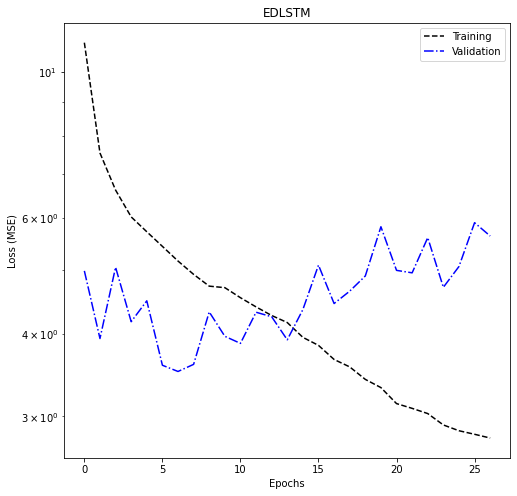

In [20]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [21]:
model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          23808     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                2

Evaluate differencing Performance

In [22]:
i=0
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered_diff = data_y_test0.loc[Y_test_predictions_diff.index]
y_test_filtered_diff = y_test_filtered_diff.squeeze(axis=1)

In [23]:
eval_df_diff = create_eval_df(Y_test_predictions_diff,y_test_filtered_diff)

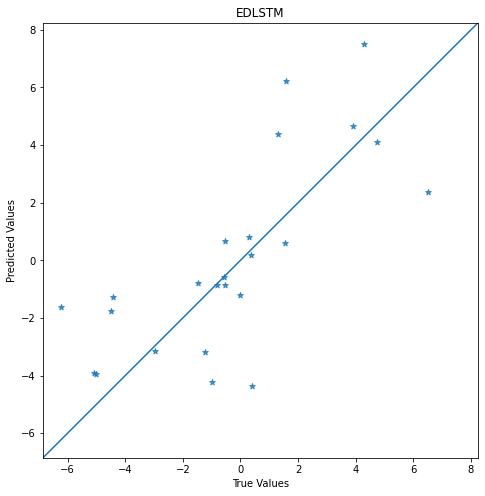

In [24]:
fig = plot_accuracy(eval_df_diff,modeltype,f"./{modeltype}/diff_accuracy_{namespace}.png")

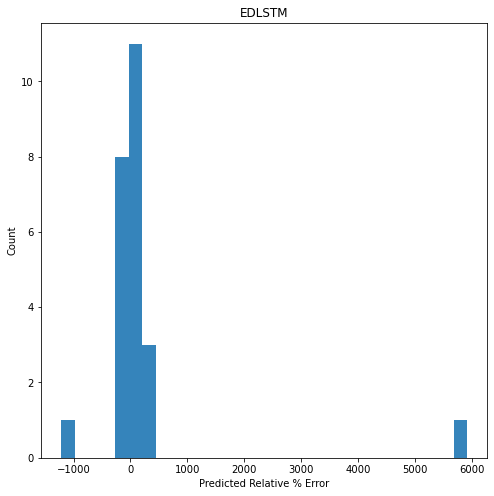

In [25]:
fig = plot_error_variations(eval_df_diff,modeltype,f"./{modeltype}/diff_error_variations_{namespace}.png")

In [26]:
abs_error_ED_LSTM = abs(Y_test_predictions_diff - y_test_filtered_diff)/y_test_filtered_diff*100
np.average(abs_error_ED_LSTM)

-199.38941789436225

In [27]:
r2_test = r2_score(y_test_filtered_diff, Y_test_predictions_diff)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.43


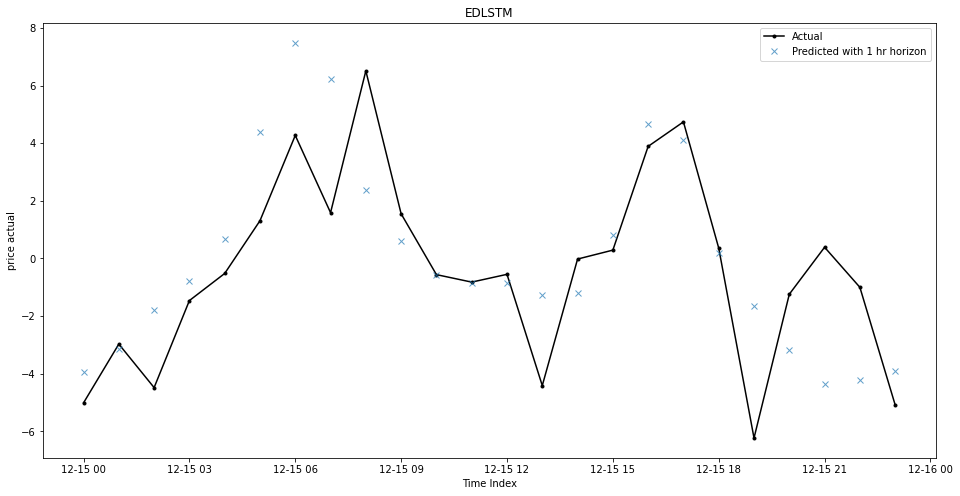

In [28]:
fig=plot_predictions(eval_df_diff,1,modeltype,feature,f"./{modeltype}/diff_predictions_{namespace}.png")

In [29]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,data_y_test0,feature,convert=False)

In [30]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

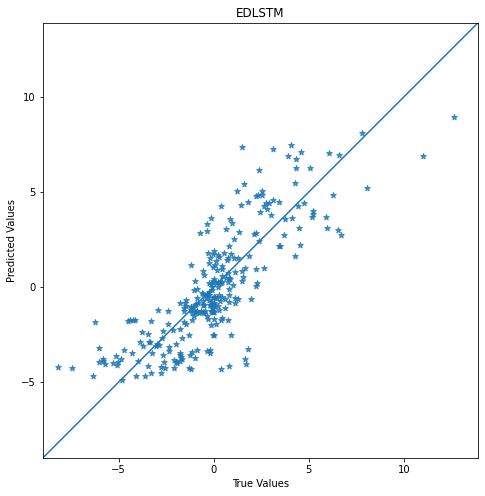

In [31]:
fig = plot_accuracy(eval_df_diff,modeltype,f"./{modeltype}/accuracy_diff_{namespace}.png")

In [32]:
# fig = plot_error_variations(eval_df_diff,modeltype,f"./{modeltype}/error_variations_diff_{namespace}.png")

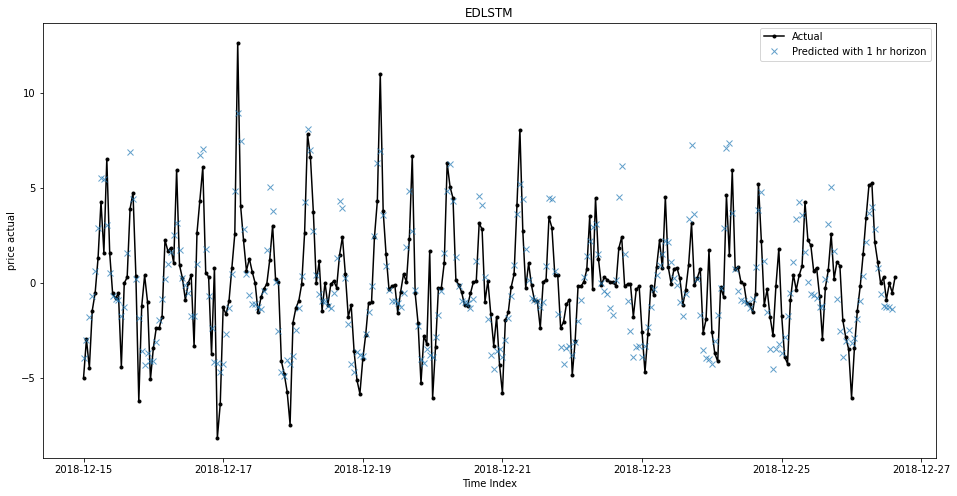

In [33]:
fig=plot_predictions(eval_df_diff,1,modeltype,feature,f"./{modeltype}/predictions_diff_{namespace}.png")

In [34]:
r2_test = r2_score(df_pred_diff['Actual'][:-1], df_pred_diff['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.59


Reverting differencing

In [35]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,base_df,feature,convert=True)

In [36]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

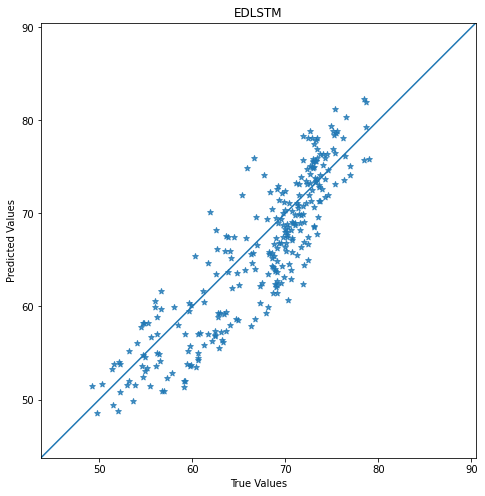

In [37]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")

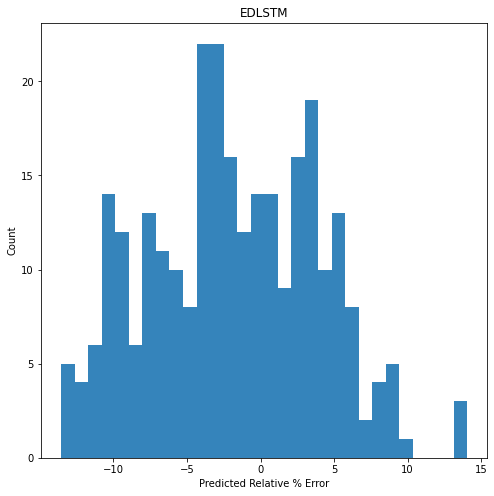

In [38]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [39]:
r2_test = r2_score(df_pred['Actual'][:-1],df_pred['mean'][:-1],)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.67


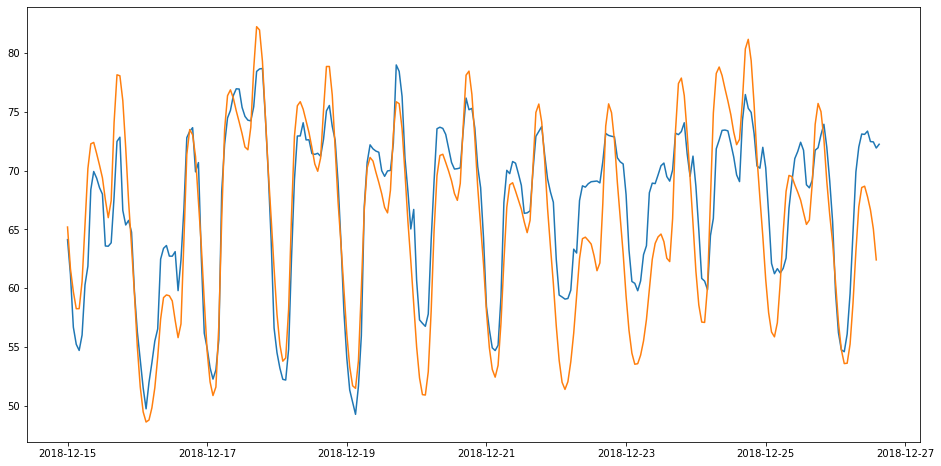

In [40]:
fig=plot_multiple_predictions(df_pred,f"./{modeltype}/multiple_predictions_bench_{namespace}.png",add_traces=False)

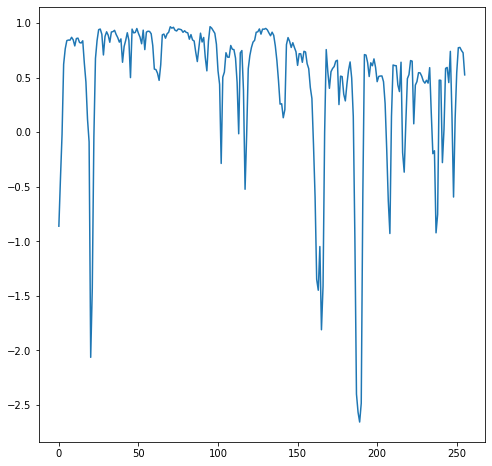

In [41]:
r2 = calculate_r2_scores(df_pred)
plt.figure()
plt.plot(r2)


Comparing to Benchmark

In [42]:
eval_df_bench = create_eval_df(bench_df[idx_test[0]:idx_test[-1]+timedelta(hours=24)],df_pred['Actual'])
eval_df_bench

,Prediction,Actual
2018-12-15 00:00:00+00:00,60.90,64.12
2018-12-15 01:00:00+00:00,58.00,61.15
2018-12-15 02:00:00+00:00,52.74,56.67
2018-12-15 03:00:00+00:00,51.25,55.21
2018-12-15 04:00:00+00:00,50.81,54.69
...,...,...
2018-12-26 11:00:00+00:00,66.66,73.36
2018-12-26 12:00:00+00:00,67.20,72.47
2018-12-26 13:00:00+00:00,67.01,72.44
2018-12-26 14:00:00+00:00,66.14,71.92


In [43]:
r2_test = r2_score(eval_df_bench['Prediction'][:-1], eval_df_bench['Actual'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.28


In [44]:
df_pred_24h = df_pred.iloc[:,0::24]
df_pred_24h['total'] = df_pred_24h.mean(axis=1)
df_pred_24h = df_pred_24h['total'].dropna()

(17880.0, 17893.958333333332)

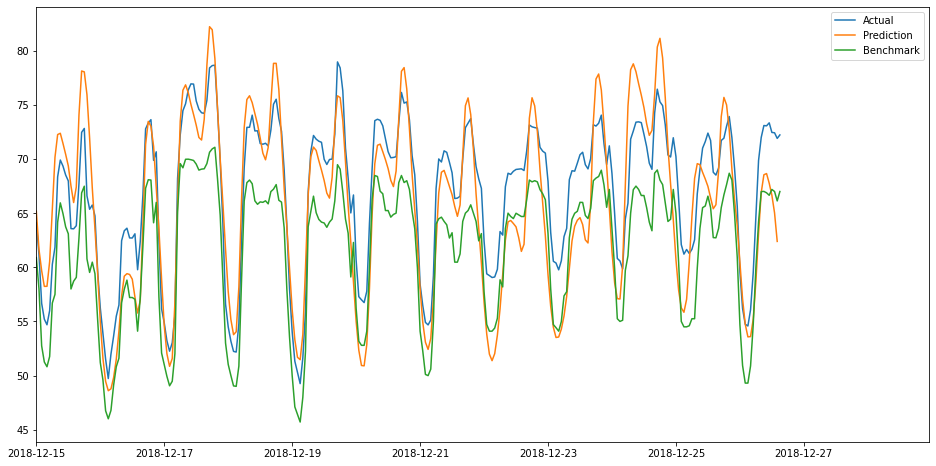

In [45]:
fig = plt.figure(figsize=(16,8))
plt.plot(df_pred['Actual'],label = 'Actual')
plt.plot(df_pred['mean'], label= 'Prediction')
plt.plot(bench_df[idx_test[0]:idx_test[-1]+timedelta(hours=24)], label = 'Benchmark')
# plt.plot(df_pred_24h,label='only24h')
plt.legend()
plt.xlim(idx_test[0],idx_test[0]+timedelta(hours=24*14-1))

Weighted Mean

In [46]:
df_pred_wm = df_pred.copy(deep=True)
df_pred_wm = remove_columns(df_pred_wm,['mean','Actual'])


In [47]:
df_pred_wm = df_pred_wm.iloc[:-1,:]

In [48]:
df_pred_wm = df_pred_wm.iloc[23:-23,:]

In [49]:
idx = df_pred_wm.index

In [50]:
cols = [f'pred_{x}h' for x in range(24,0,-1)]
new_df = pd.DataFrame()
liste=[]
for row in df_pred_wm.iterrows():
    a = list(row)
    new_series = list(a[1].dropna())
    liste.append(new_series)
weights = [x/24 for x in range(1,25,1)]
print(weights)
# weights = [x/sum(weights) for x in weights]
# print(weights)
new_list = []
for item in liste:
    new_list.append(np.average(item,weights=weights))
    
    
df_wp = pd.DataFrame(new_list,index=idx,columns=['Weighted Average Prediction'])

[0.041666666666666664, 0.08333333333333333, 0.125, 0.16666666666666666, 0.20833333333333334, 0.25, 0.2916666666666667, 0.3333333333333333, 0.375, 0.4166666666666667, 0.4583333333333333, 0.5, 0.5416666666666666, 0.5833333333333334, 0.625, 0.6666666666666666, 0.7083333333333334, 0.75, 0.7916666666666666, 0.8333333333333334, 0.875, 0.9166666666666666, 0.9583333333333334, 1.0]


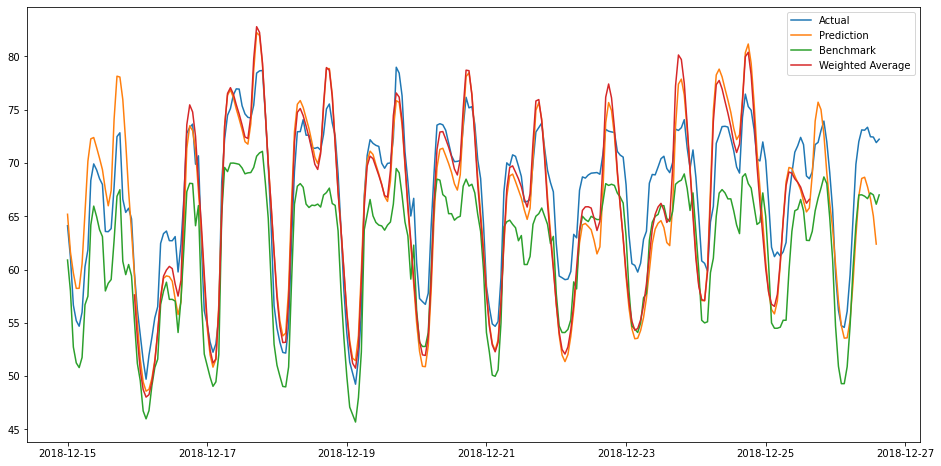

In [51]:
fig = plt.figure(figsize=(16,8))
plt.plot(df_pred['Actual'],label = 'Actual')
plt.plot(df_pred['mean'], label= 'Prediction')
plt.plot(bench_df[idx_test[0]:idx_test[-1]+timedelta(hours=24)], label = 'Benchmark')
plt.plot(df_wp,label='Weighted Average')
plt.legend()
